In [1]:
import pandas as pd

data = pd.read_csv('C:/Users/Irgi/Documents/.ipynb_checkpoints/Clear/DataKpopClearLabel.csv', delimiter = ',', error_bad_lines=False)

In [2]:
# buat variabel baru
my_df = data

#untuk menampilkan 5 baris awal
my_df.head()

,Sentimen,Tweet
0,1,gpp aespa soalnya gada idol lain se keren kali...
1,0,iya paling kerja soalnya gak punya kerjaan di ...
2,0,gue masih heran kenapa ada orang jahat cuma ga...
3,0,bahasa bayinya lo tuh cuma sebagian kecil dari...
4,0,jadi selama ini lw gk tau lagu kpop


In [3]:
my_df.dropna(inplace = True)
my_df.reset_index(drop = True, inplace = True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentimen  1066 non-null   int64 
 1   Tweet     1066 non-null   object
dtypes: int64(1), object(1)
memory usage: 16.8+ KB


In [4]:
x = my_df.Tweet
y = my_df.Sentimen

1    603
0    463
Name: Sentimen, dtype: int64


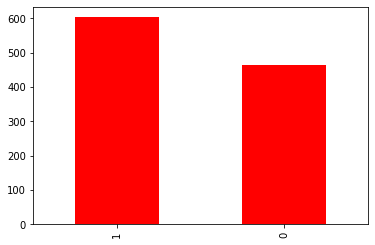

In [5]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

y_count = y.value_counts()
y_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(y.value_counts())

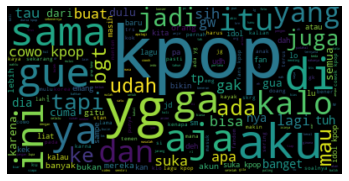

In [6]:
text = x

wordcloud = WordCloud(background_color="black").generate(' '.join(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
import sklearn

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

In [9]:
from tqdm import tqdm
tqdm.pandas(desc="progres-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [10]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [11]:
all_x = pd.concat([x_train, x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [12]:
all_x_w2v[:5]

[TaggedDocument(words=['suka', 'wanna', 'one', 'gara', 'gara', 'kang', 'daniel', 'pas', 'nonton', 'weekly', 'idol', 'abis', 'itu', 'nonton', 'produce', 'akhirnya', 'aku', 'menjadi', 'kpoperspertama', 'kali', 'suka', 'grup', 'kpop', 'dan', 'stan', 'grup', 'kpop', 'padahal', 'dulu', 'ga', 'terlalu', 'suka', 'kpop', 'eh', 'sampe', 'skarang', 'menjadi', 'kpopers', 'dan', 'bucin', 'huhu', 'jadi', 'kangen', 'wanna', 'one'], tags=['all_270']),
 TaggedDocument(words=['ampir', 'semua', 'lagu', 'kpop', 'sih', 'jujur'], tags=['all_512']),
 TaggedDocument(words=['kok', 'bisa', 'orang', 'orang', 'cowok', 'kpop', 'nya', 'banyak', 'gue', 'aja', 'udah', 'kerasa', 'pusing'], tags=['all_670']),
 TaggedDocument(words=['kw', 'ayo', 'kak', 'racunin', 'mamamu', 'kpop', 'biar', 'kalo', 'jajan', 'bareng', 'bareng', 'deh'], tags=['all_977']),
 TaggedDocument(words=['gimana', 'mau', 'move', 'on', 'baju', 'pemberian', 'mantan', 'masih', 'ngegantung', 'dilemari'], tags=['all_157'])]

In [13]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, vector_size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████████████████████████████| 1066/1066 [00:00<00:00, 532975.09it/s]


In [14]:
# pelatihan model word2vec
%timeit
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|█████████████████████████████████| 1066/1066 [00:00<00:00, 1066077.27it/s]


In [15]:
model_ug_sg = Word2Vec(sg=1, vector_size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████| 1066/1066 [00:00<00:00, 1066077.27it/s]


In [16]:
%timeit
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|█████████████████████████████████| 1066/1066 [00:00<00:00, 1066077.27it/s]


In [17]:
# simpan model word2vec

model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [18]:
from gensim.models import KeyedVectors

model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [19]:
import numpy as np
embeddings_index = {}
for w in model_ug_cbow.wv.key_to_index:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 1835 word vectors.


In [20]:
embeddings_index['film']

array([-2.93160409e-01,  3.59280616e-01,  2.29637533e-01,  3.23003918e-01,
       -1.04966141e-01, -4.00449306e-01,  2.80327559e-01,  7.26973474e-01,
       -2.34082058e-01, -4.73597571e-02, -1.46089405e-01, -3.97724718e-01,
       -2.79272228e-01,  2.05198109e-01,  1.41400710e-01, -6.39199540e-02,
        3.29767503e-02, -2.68405199e-01,  4.73384820e-02, -3.57938945e-01,
        9.81390625e-02,  4.75157946e-02,  2.63932109e-01, -4.37477008e-02,
        9.27438885e-02, -3.72206792e-02, -3.50224763e-01,  4.49251616e-03,
       -1.30640611e-01, -4.27945033e-02, -8.40225443e-02,  1.05418138e-01,
       -9.26338732e-02, -1.32244721e-01, -1.80774838e-01,  1.62526086e-01,
        2.61074722e-01,  1.32070452e-01, -3.82860422e-01, -1.14967309e-01,
        1.61300763e-01, -1.63596645e-02, -2.59881854e-01,  2.62195412e-02,
        9.36619416e-02,  1.39704486e-02,  5.12067564e-02, -1.11823499e-01,
        2.04094529e-01,  1.05531558e-01,  2.93078423e-01, -2.75189012e-01,
       -2.10371595e-02, -

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [22]:
len(tokenizer.word_index)

4335

In [23]:
for X in x_train[:5]:
    print (X)

suka wanna one gara gara kang daniel pas nonton weekly idol abis itu nonton produce akhirnya aku menjadi kpoperspertama kali suka grup kpop dan stan grup kpop padahal dulu ga terlalu suka kpop eh sampe skarang menjadi kpopers dan bucin huhu jadi kangen wanna one
ampir semua lagu kpop sih jujur 
kok bisa orang orang cowok kpop nya banyak gue aja udah kerasa pusing
kw ayo kak racunin mamamu kpop biar kalo jajan bareng bareng deh 
gimana mau move on baju pemberian mantan masih ngegantung dilemari


In [24]:
sequences[:5]

[[15,
  996,
  347,
  169,
  169,
  1586,
  1587,
  57,
  73,
  1588,
  32,
  140,
  14,
  73,
  1589,
  348,
  3,
  419,
  1590,
  104,
  15,
  85,
  1,
  13,
  90,
  85,
  1,
  153,
  45,
  8,
  229,
  15,
  1,
  129,
  64,
  1591,
  419,
  230,
  13,
  163,
  740,
  16,
  246,
  996,
  347],
 [1592, 38, 26, 1, 23, 247],
 [105, 27, 50, 50, 49, 1, 39, 51, 4, 10, 29, 489, 248],
 [490, 590, 202, 741, 1593, 1, 130, 11, 420, 491, 491, 65],
 [131, 24, 997, 349, 742, 1594, 421, 70, 1595, 1596]]

In [25]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [26]:
max(length)

55

In [27]:
x_train_seq = pad_sequences(sequences, maxlen = 55)
print ('Shape of Data Tensor:', x_train_seq.shape)

Shape of Data Tensor: (852, 55)


In [28]:
x_train_seq[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   15,
         996,  347,  169,  169, 1586, 1587,   57,   73, 1588,   32,  140,
          14,   73, 1589,  348,    3,  419, 1590,  104,   15,   85,    1,
          13,   90,   85,    1,  153,   45,    8,  229,   15,    1,  129,
          64, 1591,  419,  230,   13,  163,  740,   16,  246,  996,  347],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1592,   38,   26,    1,   23,  247],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0

In [29]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen = 55)

In [30]:
num_words = 10000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        print(word)

kpop
yg
aku
gue
di
sama
ini
ga
ya
aja
kalo
ada
dan
itu
suka
jadi
cowo
yang
juga
tapi
bgt
ke
sih
mau
tau
lagu
bisa
buat
udah
gak
lagi
idol
apa
tp
banget
dia
tuh
semua
nya
karena
gw
fans
mereka
dari
dulu
cuma
akun
gua
cowok
orang
banyak
bukan
lo
lu
gitu
bikin
pas
bener
kalau
sm
baru
udh
lebih
sampe
deh
atau
sekarang
kita
dunia
masih
kek
dah
nonton
kan
emang
klo
liat
paling
soalnya
punya
temen
kenapa
pernah
pasti
grup
kalian
kayak
jd
si
stan
jg
sering
lah
doang
pada
terus
artis
w
karna
anak
masuk
sendiri
korea
kali
kok
gk
kaya
dengan
mana
ku
trs
org
saya
makin
konser
lain
kamu
mulu
lama
emg
iya
dr
harus
hype
tu
fandom
untuk
selalu
eh
biar
gimana
beli
skrg
pertama
ak
akan
rl
tak
jarang
abis
lg
anime
pake
satu
malah
masalah
indo
bahkan
beneran
ni
ternyata
the
padahal
nama
musik
waktu
isinya
beda
mah
a
bakal
foto
bucin
and
anjir
group
jangan
naksir
gara
i
gini
an
dengerin
cewe
apalagi
album
mending
video
belum
bias
kata
gila
keluar
hati
pc
hal
dalam
siapa
mungkin
band
trus
jaman
jahat
setela

gajadi
umumnya
ilfeel
ngepoin
terhadap
busy
lebay
mantap
keganggu
brrti
down
plis
sw
sono
sepupu
ayank
n
easy
listening
pandemi
jihoon
cut
kebangetan
op
ketawa
mingyu
mesti
pastinya
dibanding
nyata
dirasa
dahlah
sealed
ikutin
mamaku
time
dipake
gbs
bgttt
berubah
tepat
anjrit
yaaaa
janjian
indah
family
makasih
dianggap
aturan
konteks
lepas
beralih
ngarep
bahasanya
kmaren
suaka
ml
kertas
season
menikmati
ngehype
utbk
tertarik
kemungkinan
shipper
cowoknya
anin
guweh
dateng
oiya
beban
voting
gaboleh
berkali
anything
manga
girlgroup
mw
close
gede
juni
mimpiin
struggle
ambil
sedikit
albumnya
om
kontak
nolak
fa
overthinking
lmao
berhasil
mix
perf
asal
unik
taeyeon
dihapus
generasi
diundang
saling
fikir
snsd
ne
gituu
tmn
minum
belanja
dengki
aduhh
kagum
onew
kesayangan
seluruh
ninggalin
tale
woy
ketawain
effort
perna
layan
sempat
waw
bl
bagi
pindah
korean
diganti
way
terkontrol
ryujin
gatauu
ridersnya
ngurusin
fanwar
rep


In [31]:
np.array_equal(embedding_matrix[69], embeddings_index.get('film'))

False

In [32]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [33]:
# persiapan proses validasi
x_new = np.concatenate((x_train_seq, x_test_seq,),axis = 0)
y_new = np.concatenate((y_train, y_test),axis = 0)

from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, random_state = 100, shuffle = True)

In [34]:
#representasi vektor kata hasil embedding python library keras
model_ptw2v = Sequential()
e = Embedding(10000, 200, input_length = 55)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation = 'relu'))
model_ptw2v.add(Dense(1, activation = 'sigmoid'))
model_ptw2v.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data = (x_test_seq, y_test), epochs = 5, batch_size = 32, verbose = 2)

Epoch 1/5
27/27 - 4s - loss: 0.7016 - accuracy: 0.5434 - val_loss: 0.6937 - val_accuracy: 0.5561 - 4s/epoch - 140ms/step
Epoch 2/5
27/27 - 3s - loss: 0.4944 - accuracy: 0.8298 - val_loss: 0.6885 - val_accuracy: 0.5561 - 3s/epoch - 99ms/step
Epoch 3/5
27/27 - 3s - loss: 0.1449 - accuracy: 0.9836 - val_loss: 0.7264 - val_accuracy: 0.5981 - 3s/epoch - 98ms/step
Epoch 4/5
27/27 - 3s - loss: 0.0245 - accuracy: 0.9977 - val_loss: 0.7983 - val_accuracy: 0.5514 - 3s/epoch - 99ms/step
Epoch 5/5
27/27 - 3s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.8203 - val_accuracy: 0.5888 - 3s/epoch - 98ms/step


In [35]:
# penyempurnaan representasi vektor kata yang telah dilatih terlebih dahulu
model_ptw2v = Sequential()
e = Embedding(10000, 200, weights = [embedding_matrix], input_length = 55, trainable = True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation = 'relu'))
model_ptw2v.add(Dense(1, activation = 'sigmoid'))
model_ptw2v.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data = (x_test_seq, y_test), epochs = 5, batch_size = 32, verbose = 2)

Epoch 1/5
27/27 - 4s - loss: 0.7243 - accuracy: 0.5528 - val_loss: 0.6692 - val_accuracy: 0.6168 - 4s/epoch - 133ms/step
Epoch 2/5
27/27 - 3s - loss: 0.2636 - accuracy: 0.9214 - val_loss: 0.8988 - val_accuracy: 0.5234 - 3s/epoch - 98ms/step
Epoch 3/5
27/27 - 3s - loss: 0.1168 - accuracy: 0.9707 - val_loss: 0.9350 - val_accuracy: 0.5841 - 3s/epoch - 99ms/step
Epoch 4/5
27/27 - 3s - loss: 0.0409 - accuracy: 0.9977 - val_loss: 1.1078 - val_accuracy: 0.6168 - 3s/epoch - 98ms/step
Epoch 5/5
27/27 - 3s - loss: 0.0157 - accuracy: 0.9988 - val_loss: 1.2199 - val_accuracy: 0.5888 - 3s/epoch - 99ms/step


In [36]:
from keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

In [37]:
# lr = 0,001
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from tensorflow.keras.optimizers import Adam

tweet_input = Input(shape = (55,), dtype = 'int32')

tweet_encoder = Embedding(10000, 200, input_length = 55)(tweet_input)
bigram_branch = Conv1D(filters = 100, kernel_size = 2, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters = 100, kernel_size = 3, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters = 100, kernel_size = 4, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis = 1)

merged = Dense(256, activation = 'relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(learning_rate = 0.001)
model = Model(inputs = [tweet_input], outputs = [output])

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 55)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 55, 200)      2000000     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 54, 100)      40100       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 53, 100)      60100       ['embedding_2[0][0]']            
                                                                                              

In [38]:
from keras.callbacks import ModelCheckpoint

filepath = "CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

fold_no = 1
for train_index, test_index, in kf.split(x_train_seq, y_train):
    print('----------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    x_tr, x_te = x_new[train_index], x_new[test_index]
    y_tr, y_te = y_new[train_index], y_new[test_index]
    # print (X_train_seq)
    # print (X_tr)
    model.fit(x_tr, y_tr, batch_size = 32, epochs = 5, validation_data = (x_te, y_te), callbacks = [checkpoint])
    fold_no = fold_no + i

----------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
22/22 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5712
Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to CNN_best_weights.01-0.5263.hdf1
INFO:tensorflow:Assets written to: CNN_best_weights.01-0.5263.hdf1\assets
22/22 [==============================] - 8s 283ms/step - loss: 0.6855 - accuracy: 0.5712 - val_loss: 0.6973 - val_accuracy: 0.5263
Epoch 2/5
22/22 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.6417
Epoch 2: val_accuracy improved from 0.52632 to 0.54971, saving model to CNN_best_weights.02-0.5497.hdf1
INFO:tensorflow:Assets written to: CNN_best_weights.02-0.5497.hdf1\assets
22/22 [==============================] - 6s 264ms/step - loss: 0.6175 - accuracy: 0.6417 - val_loss: 0.6787 - val_accuracy: 0.5497
Epoch 3/5
22/22 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.9134
Epoch 3: val_accu

In [39]:
# lr = 0,01
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from tensorflow.keras.optimizers import Adam

tweet_input = Input(shape = (55,), dtype = 'int32')

tweet_encoder = Embedding(10000, 200, input_length = 55)(tweet_input)
bigram_branch = Conv1D(filters = 100, kernel_size = 2, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters = 100, kernel_size = 3, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters = 100, kernel_size = 4, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis = 1)

merged = Dense(256, activation = 'relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(learning_rate = 0.01)
model = Model(inputs = [tweet_input], outputs = [output])

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 55)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 55, 200)      2000000     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 54, 100)      40100       ['embedding_3[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 53, 100)      60100       ['embedding_3[0][0]']            
                                                                                            

In [40]:
from keras.callbacks import ModelCheckpoint

filepath = "CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf2"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

fold_no = 1
for train_index, test_index, in kf.split(x_train_seq, y_train):
    print('----------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    x_tr, x_te = x_new[train_index], x_new[test_index]
    y_tr, y_te = y_new[train_index], y_new[test_index]
    # print (X_train_seq)
    # print (X_tr)
    model.fit(x_tr, y_tr, batch_size = 32, epochs = 5, validation_data = (x_te, y_te), callbacks = [checkpoint])
    fold_no = fold_no + i

----------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
22/22 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5433
Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to CNN_best_weights.01-0.5263.hdf2
INFO:tensorflow:Assets written to: CNN_best_weights.01-0.5263.hdf2\assets
22/22 [==============================] - 8s 290ms/step - loss: 0.6925 - accuracy: 0.5433 - val_loss: 0.7785 - val_accuracy: 0.5263
Epoch 2/5
22/22 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8311
Epoch 2: val_accuracy improved from 0.52632 to 0.57895, saving model to CNN_best_weights.02-0.5789.hdf2
INFO:tensorflow:Assets written to: CNN_best_weights.02-0.5789.hdf2\assets
22/22 [==============================] - 6s 261ms/step - loss: 0.3932 - accuracy: 0.8311 - val_loss: 1.1409 - val_accuracy: 0.5789
Epoch 3/5
22/22 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9736
Epoch 3: val_accu

In [41]:
# lr = 0,1
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from tensorflow.keras.optimizers import Adam

tweet_input = Input(shape = (55,), dtype = 'int32')

tweet_encoder = Embedding(10000, 200, input_length = 55)(tweet_input)
bigram_branch = Conv1D(filters = 100, kernel_size = 2, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters = 100, kernel_size = 3, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters = 100, kernel_size = 4, padding = 'valid', activation = 'relu', strides = 1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis = 1)

merged = Dense(256, activation = 'relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
opt = Adam(learning_rate = 0.1)
model = Model(inputs = [tweet_input], outputs = [output])

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 55)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 55, 200)      2000000     ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 54, 100)      40100       ['embedding_4[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 53, 100)      60100       ['embedding_4[0][0]']            
                                                                                            

In [42]:
from keras.callbacks import ModelCheckpoint

filepath = "CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf3"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

fold_no = 1
for train_index, test_index, in kf.split(x_train_seq, y_train):
    print('----------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    x_tr, x_te = x_new[train_index], x_new[test_index]
    y_tr, y_te = y_new[train_index], y_new[test_index]
    # print (X_train_seq)
    # print (X_tr)
    model.fit(x_tr, y_tr, batch_size = 32, epochs = 5, validation_data = (x_te, y_te), callbacks = [checkpoint])
    fold_no = fold_no + i

----------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
22/22 [==============================] - ETA: 0s - loss: 10.3025 - accuracy: 0.5081
Epoch 1: val_accuracy improved from -inf to 0.52047, saving model to CNN_best_weights.01-0.5205.hdf3
INFO:tensorflow:Assets written to: CNN_best_weights.01-0.5205.hdf3\assets
22/22 [==============================] - 8s 293ms/step - loss: 10.3025 - accuracy: 0.5081 - val_loss: 0.6995 - val_accuracy: 0.5205
Epoch 2/5
22/22 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.5712
Epoch 2: val_accuracy improved from 0.52047 to 0.52632, saving model to CNN_best_weights.02-0.5263.hdf3
INFO:tensorflow:Assets written to: CNN_best_weights.02-0.5263.hdf3\assets
22/22 [==============================] - 6s 263ms/step - loss: 0.7037 - accuracy: 0.5712 - val_loss: 0.7028 - val_accuracy: 0.5263
Epoch 3/5
22/22 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5800
Epoch 3: val_ac

In [43]:
# load model sesuai nama file diatas dengan model bobot terbaik
from keras.models import load_model

loaded_CNN_model = load_model('CNN_best_weights.01-1.0000.hdf1', compile = True)
loaded_CNN_model.evaluate(x = x_te, y = y_te)

6/6 [==============================] - 0s 33ms/step - loss: 0.0123 - accuracy: 1.0000


[0.012329320423305035, 1.0]

In [44]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen = 55)

In [45]:
# load model CNN
score = loaded_CNN_model.evaluate(x = x_te, y = y_te,)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

6/6 [==============================] - 0s 31ms/step - loss: 0.0123 - accuracy: 1.0000

ACCURACY: 1.0
LOSS: 0.012329320423305035


In [46]:
y_temp = loaded_CNN_model.predict(x_test_seq)
yhat_cnn = []
for i in range(0, len(y_temp)):
    if (y_temp[i] > 1-y_temp[i]):
        yhat_cnn.append(1)
    else:
        yhat_cnn.append(0)
    print(yhat_cnn)

[0]
[0, 0]
[0, 0, 1]
[0, 0, 1, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


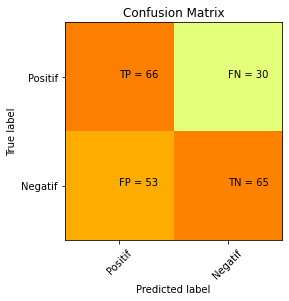

In [47]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

cm = confusion_matrix(y_test, yhat_cnn)
# print(cm)

from matplotlib.colors import ListedColormap

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Positif','Negatif']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TP','FN'], ['FP', 'TN']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

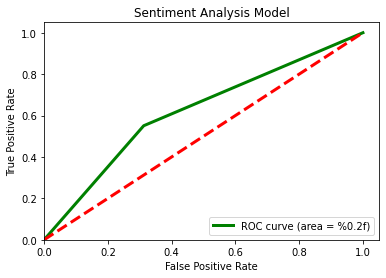

In [48]:
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, yhat_cnn, pos_label=1)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='green',
         lw=3, label='ROC curve (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sentiment Analysis Model')
plt.legend(loc="lower right")
plt.show()

In [49]:
print(classification_report(y_test, yhat_cnn, target_names=['1', '0']))

              precision    recall  f1-score   support

           1       0.55      0.69      0.61        96
           0       0.68      0.55      0.61       118

    accuracy                           0.61       214
   macro avg       0.62      0.62      0.61       214
weighted avg       0.63      0.61      0.61       214



In [50]:
data = pd.read_csv('C:/Users/Irgi/Documents/.ipynb_checkpoints/Text_Preprocessing_data_kpop.csv', delimiter = ',', error_bad_lines=False)

In [51]:
# Sentimen
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [52]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [53]:
import csv
import time

data.tail()

headerList = ['label', 'tweet', 'score', 'elapsed_time']

with open ('C:/Users/Irgi/Documents/.ipynb_checkpoints/Text_Preprocessing_data_kpop.csv', 'w', encoding = 'UTF-8', newline = '') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headerList)
    for line in data["tweet"]:
        def predict(text, include_neutral=True):
            start_at = time.time()
            # Tokenize text
            x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=55)
            # Predict
            score = loaded_CNN_model.predict(x_test)[0]
            # Decode sentiment
            label = decode_sentiment(score, include_neutral=include_neutral)
            
            return {"label": label, "tweet": line, "score": float(score), "elapsed_time": time.time()-start_at}
            
        result = predict(line)
        
        for keys, value in result.items():
            writer.writerow([value])
            print(value)

POSITIVE
pertama kali stan grup yg emang beneran seserius ini ohiya buat kak teume sebelumnya kenalin aku teume dari tmc era so proud cuz im to see  guys
0.9969035983085632
0.08000469207763672
POSITIVE
remember this one kpop stan screaming kim namjoon kim seokjin min yoongi jung hoseok park jihyo kim taehyung jeon jungkook on kcon  think  forgot
0.9451906681060791
0.0760042667388916
NEUTRAL
ada ga ya cowok diluar sana memaklumi konteks kpop ini menjadi sumber kebahagian kita lainnya tanpa mengganggu suatu 
0.6227675080299377
0.06900382041931152
POSITIVE
adek gue vvibu gara gara yoshi sama haruto dia akhirnya jadi budak kpop
0.8139462471008301
0.0760042667388916
NEUTRAL
afaik generasi di kpop bukan dibedain dari tahun debutnya aja tapi juga style lagunya dan cara mereka perform lagunya onf sama ace debutnya di pertengahan sama kaya  yang dimasukin ke rd gen kalau tbz debutnya di penghujung
0.6391718983650208
0.0760042667388916
NEGATIVE
ah iya kaya jokesnya anak kpop ya pantes aku yg pol

NEGATIVE
cocok buat yang lagi gamon tapi jangan kelamaan gamonnya harus bisa moveon okay lockeydeul ecretnumber sec
0.16104024648666382
0.06900358200073242
NEUTRAL
cowo kpop gedegede bang bisepnya
0.6383713483810425
0.08100461959838867
POSITIVE
cowo kpop ku ga krempeng klemer klemer mas
0.8308831453323364
0.08100461959838867
NEUTRAL
cowok kpop ku
0.6512476205825806
0.0740044116973877
POSITIVE
cowok kpop saya modelan nya begini bang
0.8801809549331665
0.0740041732788086
NEGATIVE
cukup standar motor aja yang ganda dunia kpop jangan dong
0.1856483817100525
0.06800365447998047
POSITIVE
cw kpop korea
0.7386597990989685
0.07300448417663574
POSITIVE
cw tiktok kpop detikdetik sebelum diusir dari rumah cr puqqymai
0.9745708107948303
0.0740041732788086
POSITIVE
da akumah suka sama cowo kpop bukan karna kerempeng ah kecuali kalo liat body ciwiciwi nya kpop tuh baru suka sedih karna ngebandingin sama body sendiri wkwkw
0.8379935622215271
0.07000398635864258
POSITIVE
dan itu rekor barutidk hnya art

POSITIVE
klo aku pribadi sih lewat jalur bantuan tuhan aku doa dan curhat klo aku stan kpop itu pilihan yang baik atau bukan buatku krna terusan curhat ke tuhan tentang itu lama jiwa kpopers ku mulai pudar dan berubah ke kesibukan dunia jadi  cara ini worth it bgt sih mnrtku
0.8541470766067505
0.07700443267822266
NEUTRAL
knp jadi ke kpop dah
0.5555707812309265
0.0760042667388916
POSITIVE
kok bisa sih ada orang sekeren ini sungguhan   the best leader in kpop world versi gue deh gw setuju ama baliho mba mba di video ini yg thanks saving mylife bcs  really made me to love myself joon namjoon
0.9798389673233032
0.06900405883789062
NEGATIVE
koreksi pann isinya kebanyakan kpop stan kaya kita dan disitu sarangnya haters buat nge julid kebanyakan rumor idol sumbernya dari pann dan pann sendiri udah terkenal sering nyebarin misleading information karena emang tujuannya nyari klik di artikelnya supaya dapat cuan
0.12960511445999146
0.07300448417663574
NEUTRAL
kpop company rata pas ngeluarin lagu

POSITIVE
pingin rest bentar dari perkpopan tapi tl isinya tentang new album seventeen fan meeting exo sama first concert treasure ya mana bisa atuh
0.8337928652763367
0.07000398635864258
POSITIVE
repliesnya cewe yang suka kpop seleranya tinggi mas tapi iya bner
0.9706512689590454
0.07200407981872559
NEUTRAL
sama aku sekarang udah ga ngikutin kpop lagi bukan berati gasuka ya aku nyibukin diri nder cari kesenangan lain gausa terlalu mantengin updatean dari idol gitu deh
0.4470404386520386
0.06900405883789062
NEUTRAL
sefanatik itu alhamdulillah sekarang aku klo liat idol kpop  aja gtu ga kek dlu yg harus tau faktanya makanan fav lagu fav dll aku lebih fokus ke sejarah islam sekarang ya walaupun di akun ig second masih foll base kpop tpi aku jarang buka berandanya aku lebih ke
0.572620153427124
0.0870048999786377
NEGATIVE
seganteng gantengnya cowo kpop dan aktor korea cuma orang ini yang bisa bikin aku meleyot padahal mereka gak ngapa ngapain gamungkin kan hyunsik sama songkang bakal masuk